In [64]:
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import pandas as pd
import datetime
import matplotlib.ticker as ticker
sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19
from header_plotting import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)

In [36]:
# Load data
countries = ['England', 'Czechia', 'Scotland', 'Spain', 'Italy',
       'Germany','France']
traces, models, dls = [], [], []
offset_data = -14
traces,traces_without_soccer,traces_primary_soccer, models, dls = [], [], [], [],[]

for country in tqdm(countries):
    model = None
    fstr=lambda tune, draws, max_treedepth: (f"/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run"+
            f"-beta=False"+
            f"-country={country}"+
            f"-offset_data={offset_data}"+
            f"-prior_delay=-1"+
            f"-median_width_delay=1.0"+
            f"-interval_cps=10.0"+
            f"-f_fem=0.33"+
            f"-len=normal"+
            f"-abs_sine=False"+
            f"-t={tune}"+
            f"-d={draws}"+
            f"-max_treedepth={max_treedepth}.pkl")
    #print(fstr(4000, 8000, 12))
    if os.path.exists(fstr(2000, 4000, 12)):
        try:
            model, trace = load(fstr(2000, 4000, 12))
            #print(f"Use 4000 sample runs for {country}")
        except:
            pass
    if model is None: 
        print(country + " "+ fstr(2000, 4000, 12), " not found")
        continue
    
    # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
    mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
    trace.posterior = trace.posterior.sel(chain=~mask)
    
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country],offset_games=offset_data,offset_data=0)
    
    trace_without_soccer, trace_primary_soccer = load(f"/data.nst/smohr/covid19_soccer_data/primary_and_subsequent/{country}_offset_{offset_data}.pkl")
    traces_without_soccer.append(trace_without_soccer)
    traces_primary_soccer.append(trace_primary_soccer)

    models.append(model)
    traces.append(trace)
    dls.append(dl)


  0%|          | 0/7 [00:00<?, ?it/s]

In [70]:
dls = [covid19_soccer.dataloader.Dataloader_gender(countries=[country],offset_games=offset_data,offset_data=offset_data) for country in countries ]

In [37]:
infections_no = []
infections_primary = []
infections_subsequent = []
for i, country in enumerate(countries):
    shape = traces_without_soccer[i].predictions["new_cases"].to_numpy().shape
    x = pd.date_range(models[i].sim_begin, models[i].sim_end)
    y0 = get_from_trace("new_cases",traces_without_soccer[i],from_type="predictions")
    y1 = get_from_trace("new_cases",traces_primary_soccer[i],from_type="predictions") - y0
    y2 = get_from_trace("new_cases",traces[i]) - y1 - y0

    begin = datetime.datetime(2021, 6, 11)
    end = datetime.datetime(2021, 7, 31)
    i_begin = (begin - models[i].sim_begin).days
    i_end = (end - models[i].sim_begin).days + 1  # inclusiv last day

    y0 = np.sum(y0[..., i_begin:i_end, :], axis=-2)
    y1 = np.sum(y1[..., i_begin:i_end, :], axis=-2)
    y2 = np.sum(y2[..., i_begin:i_end, :], axis=-2)

    infections_no.append(y0)
    infections_primary.append(y1)
    infections_subsequent.append(y2)
    
data_primary  = pd.DataFrame()
medians = []
for i,country in enumerate(countries):
    # compute fraction of infected people
    t_numpy = infections_primary[i] / (infections_no[i] + infections_primary[i] + infections_subsequent[i]) * 100
    print(t_numpy.shape)
    male = np.stack(
        (t_numpy[:, 0], np.zeros(t_numpy[:, 0].shape)), axis=1
    )
    female = np.stack(
        (t_numpy[:, 1], np.ones(t_numpy[:, 1].shape)), axis=1
    )
    # Create dataframe for plotting
    temp = pd.DataFrame(np.concatenate((male, female)), columns=["percentage_primary", "gender"])
    temp["gender"] = pd.cut(
        temp["gender"], bins=[-1, 0.5, 1], labels=["male", "female"]
    )
    temp["country"] = country
    data_primary = pd.concat([data_primary, temp])
    medians.append(np.median(temp["percentage_primary"]))
country_order_primar = np.argsort(medians)[::-1]

data_primary_and_subsequent = pd.DataFrame()
medians = []
for i, country in enumerate(countries):

    # compute fraction
    t_numpy = (infections_primary[i]+infections_subsequent[i])/(infections_no[i] + infections_primary[i] + infections_subsequent[i]) * 100

    male = np.stack(
        (t_numpy[:, 0], np.zeros(t_numpy[:, 0].shape)), axis=1
    )
    female = np.stack(
        (t_numpy[:, 1], np.ones(t_numpy[:, 1].shape)), axis=1
    )
    # Create dataframe for plotting
    temp = pd.DataFrame(np.concatenate((male, female)), columns=["percentage_primary_and_subsequent", "gender"])
    temp["gender"] = pd.cut(
        temp["gender"], bins=[-1, 0.5, 1], labels=["male", "female"]
    )
    temp["country"] = country
    data_primary_and_subsequent = pd.concat([data_primary_and_subsequent, temp])
    medians.append(np.median(temp["percentage_primary_and_subsequent"]))
country_order_primary_and_subsequent = np.argsort(medians)[::-1]


# Compute interesting values as fraction, as incidence and as cases
primary_frac = []
for i, country in enumerate(countries):
    temp = data_primary[data_primary["country"] == country].drop(columns=["country"])
    temp_m = temp[temp["gender"]=="male"].drop(columns=["gender"])
    temp_f = temp[temp["gender"]=="female"].drop(columns=["gender"])
    primary_frac.append(np.array([temp_m.to_numpy()[:,0],temp_f.to_numpy()[:,0]]))

primary_and_subsequent_frac = []
for i, country in enumerate(countries):
    temp = data_primary_and_subsequent[data_primary_and_subsequent["country"] == country].drop(columns=["country","gender"])
    primary_and_subsequent_frac.append(temp.to_numpy()[:,0])

primary_inci = []
for i, country in enumerate(countries):
    temp = infections_primary[i]
    primary_inci.append(temp / dls[i].population[0]*1e6)

primary_and_subsequent_inci = []
for i, country in enumerate(countries):
    temp = infections_primary[i] + infections_subsequent[i]
    primary_and_subsequent_inci.append(temp/ dls[i].population[0]*1e6)

primary_cases = []
for i, country in enumerate(countries):
    temp = infections_primary[i]
    primary_cases.append(temp)

primary_and_subsequent_cases = []
for i, country in enumerate(countries):
    temp = infections_primary[i] + infections_subsequent[i]
    primary_and_subsequent_cases.append(temp)
    

(24000, 2)
(32000, 2)
(32000, 2)
(32000, 2)
(32000, 2)
(32000, 2)
(32000, 2)


In [38]:
def whisker_plot_v(ax,x,y_median,y_lower_95,y_upper_95,y_lower_68,y_upper_68):
    lines = ax.vlines(
        x=x,
        ymin=y_lower_95,
        ymax=y_upper_95,
        lw=1.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines = ax.vlines(
        x=x,
        ymin=y_lower_68,
        ymax=y_upper_68,
        lw=2.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines.set_capstyle("round")
    ax.scatter(
        x=x,
        y=y_median,
        marker="o",
        s=10,
        zorder=10,
        c="white",
        edgecolor="#060434",
    )
    ax.axhline(0, color="tab:gray", ls="--", zorder=-10)
    ax.spines["bottom"].set_visible(False)
    ax.tick_params(axis="y",bottom=False)

/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:1171: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_male, lw=0,),)
/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:1175: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_female, lw=0,),)
<ipython-input-76-5ce3056e0487>:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


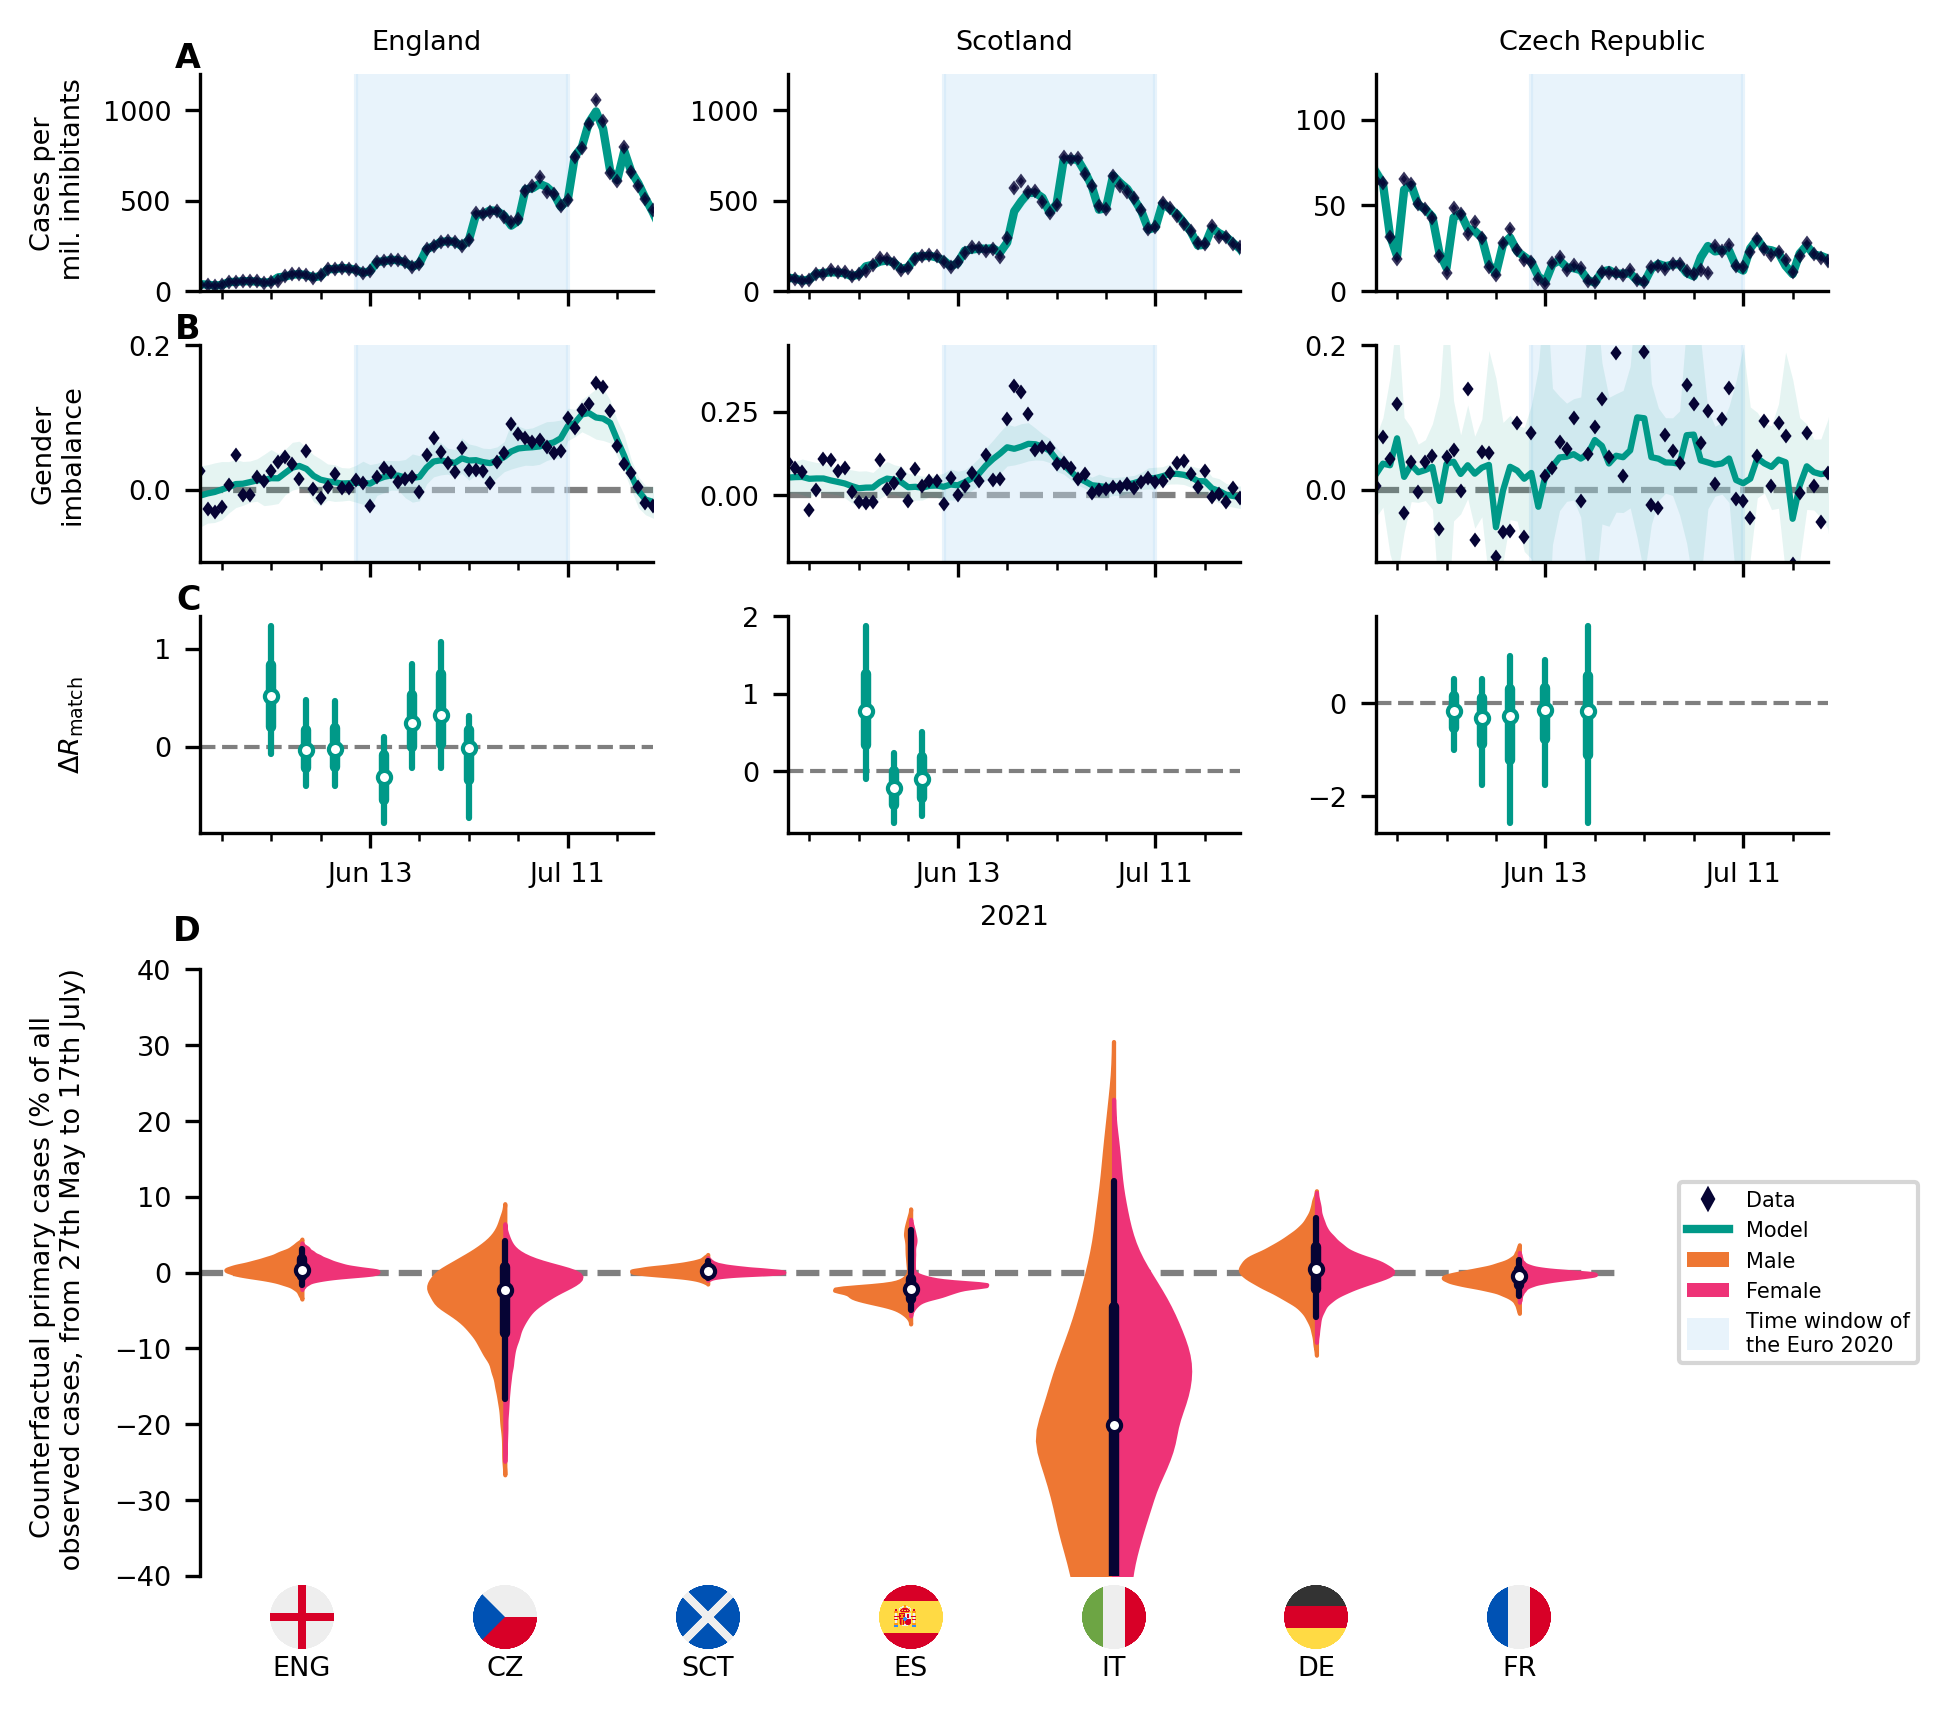

In [76]:
from covid19_soccer.plot.other import hviolins, legend, plot_flags
xlim_ts = [datetime.datetime(2021,5,20),datetime.datetime(2021,7,23)] # Plotting range
country_order = range(7)
selected_index = [0,2,1]

# Create figure
plt.close("all")
fig = plt.figure(figsize=(7, 6.5))
axes, outer_outer_grid = covid19_soccer.plot.overview.multi_v2(
    traces=traces,
    models=models,
    dls=dls,
    xlim=xlim_ts,
    selected_index=[0,2,1],
    nColumns=3,
    fig=fig,
    ypos_flags=-40,
    country_order=country_order,
    shift_model=-14,
    shift_data=-14
)

# Add label letters to figure
letters = np.array(list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"))
text_kwargs = {
    "fontsize":8,
    "fontweight":"bold",
    "verticalalignment":"top",
    "ha":"right"
}
axes[0][0].text(
    s=letters[0],
    transform=axes[0][0].transAxes,
    x=0,
    y=1.15,
    **text_kwargs
)
axes[0][1].text(
    s=letters[1],
    transform=axes[0][1].transAxes,
    x=0,
    y=1.15,
    **text_kwargs
)
axes[0][2].text(
    s=letters[2],
    transform=axes[0][2].transAxes,
    x=0,
    y=1.15,
    **text_kwargs
)


axes[0][0].set_ylim(0,1200)
axes[1][0].set_ylim(0,1200)

axes[0][0].set_ylabel("Cases per\n mil. inhibitants")

axes[1][2].set_xlabel("2021")
axes[0][2].set_ylabel("$\Delta R_{\mathrm{match}}$")



axes[0][1].set_ylim(-0.1,0.2)
axes[1][1].set_ylim(-0.2,0.45)
axes[2][1].set_ylim(-0.1,0.2)


inner_grid = outer_outer_grid[-1].subgridspec(1, 2, width_ratios=(12.0, 0.5))

# Plot percentage of soccer
ax = fig.add_subplot(inner_grid[0, 0])

hviolins(
    ax,
    primary_frac,
    countries
)
ci = [np.percentile(pf,q = (2.5,50,97.5,50-34,50+34)) for pf in primary_frac]
ci = np.array(ci).T
whisker_plot_v(
    ax,
    countries,
    ci[1,:],ci[0,:],ci[2,:],ci[3,:],ci[4,:]
)
ax.set_ylabel("Counterfactual primary cases (% of all \n observed cases, from 27th May to 17th July)")
ax.set_ylim(-40,40)
ax.set_xlim(-0.5,6.5)
ax.text(
    s=letters[3],
    transform=ax.transAxes,
    x=0,
    y=1.09,
    **text_kwargs
)
ax.get_legend().remove()

labels = [dl.countries_iso2[0].replace("GB-","") for dl in dls]
plot_flags(
    ax,
    labels,
    -40
)
ax.set_xticklabels(labels)
ax.set_xlabel(None)
import matplotlib.transforms as mtrans
trans = mtrans.Affine2D().translate(0, -50)
labels = ax.get_xticklabels()
for label in labels:
    label.set_transform(label.get_transform()+trans)
ax.xaxis.set_ticks_position('none') 
ax = fig.add_subplot(inner_grid[0, 1])
legend(ax=ax, posterior=False, prior=False, championship_range=True)


plt.tight_layout()
fig.align_ylabels()

# Save figure as pdf and png        
save_kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}
fig.savefig(f"../figures/SI/overview_infections_offset_-14.pdf", **save_kwargs)
fig.savefig(f"../figures/SI/overview_infections_offset_-14.png", **save_kwargs)

plt.show()
plt.close(fig=fig)